# 1 - Librariers Importing
---

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web
from functools import reduce
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter



In [2]:
def display(data):
	print(tabulate(data, headers = 'keys', tablefmt = 'psql'))
	return

# 2 - Data Importing
---
## 2.1 - Import the series for all instruments (11) from 01-01-2015 to  16-04-2020
We get a list (11-length) of dataframes (6-column)

In [3]:
# 1 - Define `tickers` & `company names` for every instrument
stocks      = {'AAPL':'Apple', 'MSFT':'Microsoft', 'AMZN' : 'Amazon',  'GOOG': 'Google', 'FB':'Facebook','NFLX':'Netflix' ,  'NVDA' : 'NVIDIA'}
bonds       = {'HCA' : 'HCA', 'VRTX' :  'VRTX'}
commodities = {'BTC-USD' : 'Bitcoin', 'PA=F' : 'Palladium'}
instruments = {**stocks, **bonds, **commodities}
tickers     = list(instruments.keys())
instruments_data = {}
N = len(tickers)


# 2 - We will look at stock prices over the past years, starting at January 1, 2015
#                               01-01-2015 - 16-04-2020
start = datetime.datetime(2015,1,1)
end   = datetime.datetime(2020,4,16)

# 3 - Let's get instruments data based on the tickers.
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
for ticker, instrument in instruments.items():
  print("Loading data series for instrument {} with ticker = {}".format(instruments[ticker], ticker))
  instruments_data[ticker] = web.DataReader(ticker, data_source = 'yahoo', start = start, end = end)


Loading data series for instrument Apple with ticker = AAPL
Loading data series for instrument Microsoft with ticker = MSFT
Loading data series for instrument Amazon with ticker = AMZN
Loading data series for instrument Google with ticker = GOOG
Loading data series for instrument Facebook with ticker = FB
Loading data series for instrument Netflix with ticker = NFLX
Loading data series for instrument NVIDIA with ticker = NVDA
Loading data series for instrument HCA with ticker = HCA
Loading data series for instrument VRTX with ticker = VRTX
Loading data series for instrument Bitcoin with ticker = BTC-USD
Loading data series for instrument Palladium with ticker = PA=F


In [4]:
instruments_data['AAPL']

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,27.860001,26.837500,27.847500,27.332500,212818400.0,24.696352
2015-01-05,27.162500,26.352501,27.072500,26.562500,257142000.0,24.000614
2015-01-06,26.857500,26.157499,26.635000,26.565001,263188400.0,24.002876
2015-01-07,27.049999,26.674999,26.799999,26.937500,160423600.0,24.339447
2015-01-08,28.037500,27.174999,27.307501,27.972500,237458000.0,25.274624
...,...,...,...,...,...,...
2020-04-09,67.517502,66.175003,67.175003,66.997498,162116400.0,66.040802
2020-04-13,68.425003,66.457497,67.077499,68.312500,131022800.0,67.337029
2020-04-14,72.062500,69.512497,70.000000,71.762497,194994800.0,70.737755


## 2.3 - Keep only `Adjusted Close` prices & Drop duplicates
We  keep the 11-length list of dataframes (1-column eventually). We will merge later on

In [5]:
## 2.3.1 - keep only `adjusted close` prices
for ticker, instrument in instruments.items():
  instruments_data[ticker] = instruments_data[ticker]["Adj Close"]


In [6]:
## 2.3.2 - Drop duplicates for palladium data from Yahoo Source 
instruments_data['PA=F'] = instruments_data['PA=F'].drop_duplicates()


## 2.4 - Inspect total trading days for all instruments ( = lengths of the respective dataframes)

In [7]:
tr_days = [ len(instr) for _, instr in instruments_data.items() ] 
tr_days = pd.DataFrame(tr_days, index = tickers, columns = ["Trading Days"])

In [8]:
tr_days.T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Trading Days,1331,1331,1331,1331,1331,1331,1331,1331,1331,1934,1335


In [9]:
tr_days_stocks_bonds = instruments_data['AAPL'].groupby([instruments_data['AAPL'].index.year]).agg('count')
tr_days_bitcoin      = instruments_data['BTC-USD'].groupby([instruments_data['BTC-USD'].index.year]).agg('count')
tr_days_palladium    = instruments_data['PA=F'].groupby([instruments_data['PA=F'].index.year]).agg('count')


tr_days_per_year = pd.DataFrame([tr_days_stocks_bonds,tr_days_bitcoin, tr_days_palladium], index = ["Stocks & Bonds", "Bitcoin", "Palladium"])


In [10]:
tr_days_per_year

Date,2015,2016,2017,2018,2019,2020
Stocks & Bonds,252,252,251,251,252,73
Bitcoin,365,366,365,365,365,108
Palladium,244,241,237,238,291,84


## 2.5 - Merging Dataframes
We convert the 11-length dictionary, to a new dataframe (11-column). Each column stands for the Adjusted Close price of the respective instrument.
* I tried using `pd.concat` but failed because of different sizes between 'Bitcoin' series and 'Palladium' series.
* We used `reduce` from `functools`, worked just fine

The result is a `dataframe` with shape $$1271 \times 11$$ 
so the common trading days were only T = 1271. Without `Palladium` the common tradings days were T = 1331 (so no recrods would be removed from stocks and bonds)


In [11]:
## 2.4 - Merging Dataframes
'''
    instruments_data = {'AAPL' : dataframe (1331 x 1),..., 'BTC-USD' : dataframe (1934 x 1), 'PA=F' : dataframe (1336 x 1)}
    [*] So list(instruments_data.values()) : we only keep the dataframes in a list
    [*] data_df = pd.concat(data, axis = 1).dropna() DID not wor because of different `commodities` sizes

'''
data = list(instruments_data.values())
data_df = reduce(lambda x, y: pd.merge(x, y, left_index = True, right_index = True, how = 'outer'), data).dropna()
data_df.columns = tickers


In [12]:
data_df

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Date,,,,,,,,,,,
2015-01-02,24.696352,41.647892,308.519989,523.373108,78.449997,49.848572,19.380514,71.915703,123.070000,315.032013,794.849976
2015-01-05,24.000614,41.264908,302.190002,512.463013,77.190002,47.311428,19.053175,69.815681,121.029999,274.473999,793.200012
2015-01-06,24.002876,40.659245,295.290009,500.585632,76.150002,46.501427,18.475513,69.699020,117.360001,286.188995,800.400024
2015-01-07,24.339447,41.175831,298.420013,499.727997,76.150002,46.742859,18.427374,70.962906,120.660004,294.337006,792.450012
2015-01-08,25.274624,42.387146,300.459991,501.303680,78.180000,47.779999,19.120564,72.849030,123.970001,283.348999,793.099976
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08,65.567657,164.274277,2043.000000,1210.280029,174.279999,371.119995,266.748444,107.998520,249.660004,7302.089355,2123.699951
2020-04-09,66.040802,164.284225,2042.760010,1211.449951,175.190002,370.720001,262.751465,107.998520,246.610001,6865.493164,2138.500000
2020-04-13,67.337029,164.652313,2168.870117,1217.560059,174.789993,396.720001,269.646240,103.551056,252.279999,6842.427734,2199.199951


In [13]:
tr_days_per_year = data_df['AAPL'].groupby([data_df['AAPL'].index.year]).agg('count')
tr_days_per_year = pd.DataFrame([tr_days_per_year], index = ["All instruments (merged)"])

In [14]:
tr_days_per_year

Date,2015,2016,2017,2018,2019,2020
All instruments (merged),244,241,237,237,242,70


## 2.6 - Plot `Adj Close` together


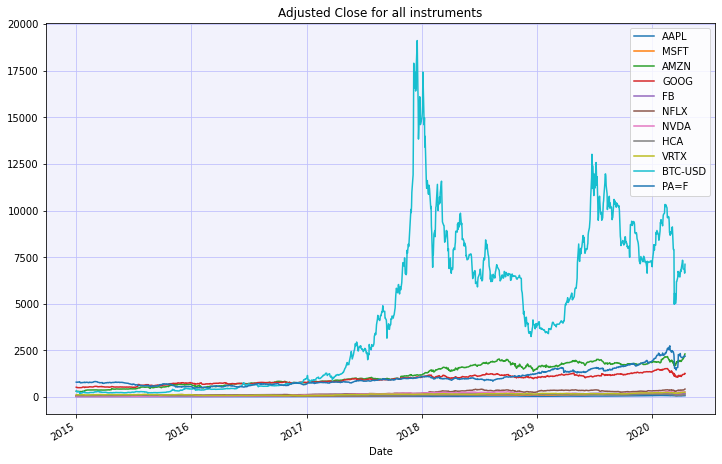

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
data_df.plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for all instruments')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

# 3 - Calculate Descriptive Statistics
---


## 3.1 - Return
### Daily
---
A “better” solution, though, would be to plot the information we actually want: the stock’s returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply
* **Simple Returns** : One transformation would be to consider the stock’s return since the beginning of the period of interest. In other words, we plot:
$$r_t = \frac{P_t}{P_0} - 1$$
* **Log Returns**
$$r_t = ln\left(\frac{P_t}{P_0}\right)$$

### Annual 
---
$$APR = R_{nominal} = r_{N} = ln\left(\frac{P_N}{P_0}\right) = ln\left(\frac{P_N}{P_{N-1}}\cdot \frac{P_{N-1}}{P_{N-2}} \cdot ... \frac{P_1}{P_{0}}\right)$$

$$APY = (1 + \frac{APR}{N})^{N} - 1 \longrightarrow R_{effective} = (1 + \frac{R_{nominal} }{N})^{N} - 1$$


### 3.1.1 - **Daily** : Simple Returns
It is similar to the actual value $P_t$, since the transformation do not affect much.

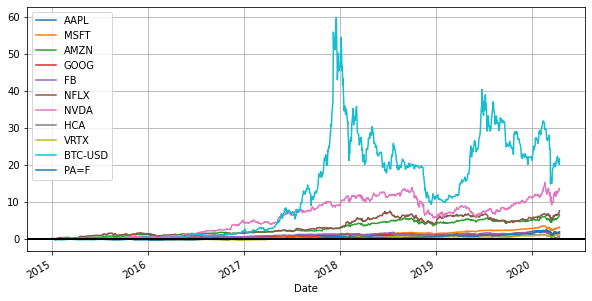

In [16]:
simple_returns = data_df.apply(lambda x: x / x[0] - 1)
simple_returns.plot(grid = True, figsize = (10,5)).axhline(y = 0, color = "black", lw = 2)

### 3.1.2 - **Daily** :  Log Returns

In [17]:
log_returns = data_df.pct_change()

In [18]:
log_returns

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Date,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.028172,-0.009196,-0.020517,-0.020846,-0.016061,-0.050897,-0.016890,-0.029201,-0.016576,-0.128743,-0.002076
2015-01-06,0.000094,-0.014677,-0.022833,-0.023177,-0.013473,-0.017121,-0.030318,-0.001671,-0.030323,0.042682,0.009077
2015-01-07,0.014022,0.012705,0.010600,-0.001713,0.000000,0.005192,-0.002606,0.018133,0.028119,0.028471,-0.009933
2015-01-08,0.038422,0.029418,0.006836,0.003153,0.026658,0.022188,0.037617,0.026579,0.027432,-0.037331,0.000820
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08,0.025595,0.010031,0.015609,0.020034,0.032281,-0.003116,0.030576,0.095832,0.008035,-0.004364,0.000424
2020-04-09,0.007216,0.000061,-0.000117,0.000967,0.005222,-0.001078,-0.014984,0.000000,-0.012217,-0.059791,0.006969
2020-04-13,0.019628,0.002241,0.061735,0.005044,-0.002283,0.070134,0.026241,-0.041181,0.022992,-0.003360,0.028384


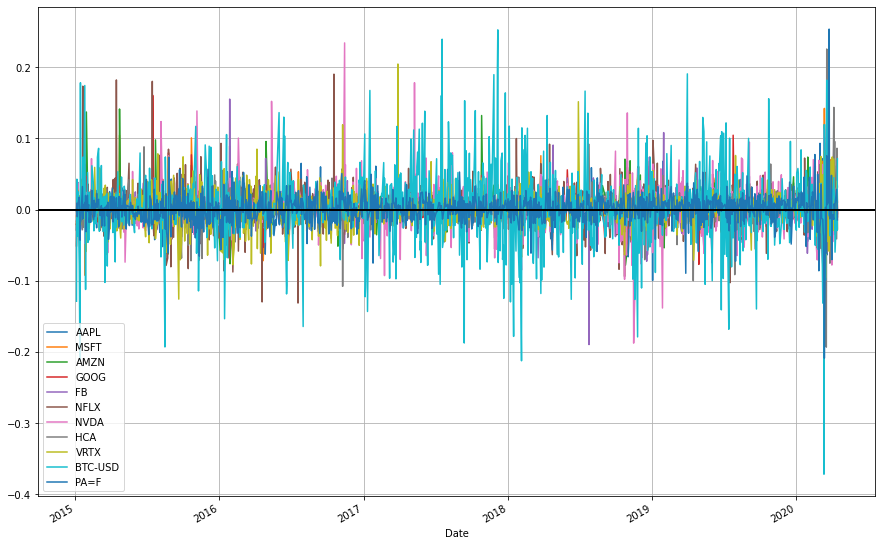

In [19]:
log_returns.plot(grid = True, figsize = (15,10)).axhline(y = 0, color = "black", lw = 2)

### 3.2.1 - **Annual** :  APR or $r_{nominal}$

In [20]:
APR = log_returns.groupby([log_returns.index.year]).agg('sum')
APR_avg = APR.mean()


In [21]:
APR

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Date,,,,,,,,,,,
2015,0.014835,0.236813,0.839436,0.413261,0.321211,0.956530,0.567932,-0.041666,0.108067,0.533104,-0.305389
2016,0.145483,0.166098,0.146655,0.038112,0.135068,0.180147,1.275917,0.123294,-0.441285,0.921853,0.240298
2017,0.410618,0.352656,0.465379,0.316057,0.441634,0.475668,0.676923,0.192419,0.779433,3.161591,0.479161
2018,-0.016302,0.225484,0.312614,0.030426,-0.222694,0.434708,-0.240322,0.391116,0.154390,-1.049292,0.186203
2019,0.672268,0.476075,0.234382,0.285456,0.487580,0.250397,0.656144,0.220984,0.313167,0.879401,0.462310
2020,0.030241,0.149216,0.253045,-0.016012,-0.098808,0.322787,0.273546,-0.172080,0.202091,0.149201,0.234454


In [22]:
pd.DataFrame(APR_avg, columns = ['Average APR']).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average APR,0.209524,0.267724,0.375252,0.177883,0.177332,0.436706,0.535023,0.119011,0.185977,0.765976,0.216173


### 3.2.2 - **Annual** :  APY or $r_{effective}$

In [23]:
N = np.array(tr_days_per_year.T)
N_total = np.sum(N)
APY = (1  + APR / N )**N - 1
APY_avg = (1  + APR_avg /N_total  )**N_total - 1


In [24]:
APY

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Date,,,,,,,,,,,
2015,0.014945,0.267059,1.311728,0.511211,0.378505,1.597786,0.763451,-0.040813,0.114095,0.703223,-0.263304
2016,0.156547,0.180621,0.157903,0.038845,0.144572,0.197313,2.569949,0.131181,-0.357051,1.509527,0.271476
2017,0.507213,0.422469,0.591890,0.371420,0.554607,0.608321,0.965915,0.212083,1.177448,22.119789,0.613938
2018,-0.016170,0.252794,0.366712,0.030892,-0.199724,0.543897,-0.213721,0.478154,0.166888,-0.650629,0.204579
2019,0.956849,0.608991,0.263984,0.330145,0.627573,0.284368,0.925636,0.247178,0.367473,1.405618,0.587038
2020,0.030696,0.160740,0.287354,-0.015886,-0.094146,0.379947,0.313917,-0.158266,0.223603,0.160721,0.263723


In [25]:
pd.DataFrame(APY_avg, columns = ['Average APY']).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average APY,0.233069,0.306949,0.455277,0.194671,0.194013,0.547485,0.707296,0.126376,0.204378,1.150597,0.241294


## 3.2 - Risk (Volatility Risk of returns)
* **Variance** $\sigma^2$
$$Var(R) = \sigma^2 = \frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}$$
* **Standard Deviation** $\sigma$
$$\sigma =\sqrt{\sigma^2} = \sqrt{\frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}}$$
where $R_t = $ log price of instrument $i$ at the time $t$


### 3.2.1 - Standard Deviation

In [26]:
STD       = log_returns.groupby([log_returns.index.year]).agg('std') * np.sqrt(N)
STD_avg   = STD.mean()
std       = log_returns.std()

In [27]:
STD

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Date,,,,,,,,,,,
2015,0.268904,0.281181,0.335684,0.294189,0.257050,0.510724,0.345610,0.310764,0.414629,0.658472,0.295032
2016,0.236506,0.226659,0.293497,0.205495,0.288083,0.450801,0.432221,0.255874,0.432884,0.481676,0.296041
2017,0.174892,0.147314,0.206433,0.152111,0.164687,0.273907,0.397368,0.206675,0.383921,0.932246,0.227438
2018,0.279793,0.270630,0.352691,0.285684,0.379418,0.452252,0.500216,0.248676,0.331474,0.781625,0.249144
2019,0.264377,0.205582,0.233186,0.245670,0.280377,0.348977,0.411802,0.268981,0.263057,0.674833,0.287120
2020,0.347905,0.349006,0.249377,0.288511,0.313574,0.302663,0.438226,0.499712,0.315273,0.528132,0.453181


In [28]:
pd.DataFrame(STD_avg, columns = ['Average STD']).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average STD,0.262063,0.246729,0.278478,0.245277,0.280532,0.389887,0.420907,0.298447,0.356873,0.676164,0.301326


### 3.2.2 - Visualize `standard deviation` for all instruments for all years

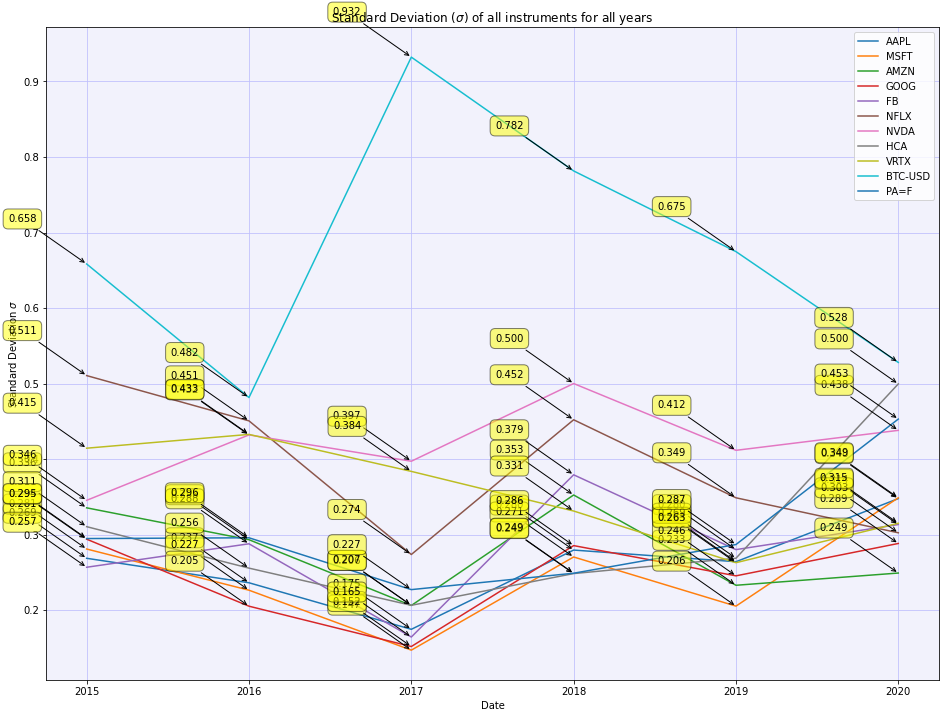

In [29]:
# configuration
fig, ax = plt.subplots(figsize = (16,12))
ax.set_title(r"Standard Deviation ($\sigma$) of all instruments for all years")
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_ylabel(r"Standard Deviation $\sigma$")
ax.set_xlabel(r"Years")
STD.plot(ax = plt.gca(),grid = True)

for instr in STD:
  stds = STD[instr]
  years = list(STD.index)
  for year, std in zip(years, stds):
    label = "%.3f"%std
    plt.annotate(label, xy = (year, std), xytext=((-1)*50, 40),textcoords = 'offset points', ha = 'right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
      arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


### 3.2.3 - Variance

In [30]:
VAR = STD **2
VAR_avg = VAR.mean()

In [31]:
VAR

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Date,,,,,,,,,,,
2015,0.072310,0.079063,0.112684,0.086547,0.066075,0.260839,0.119447,0.096575,0.171917,0.433586,0.087044
2016,0.055935,0.051374,0.086140,0.042228,0.082992,0.203222,0.186815,0.065472,0.187389,0.232012,0.087640
2017,0.030587,0.021702,0.042614,0.023138,0.027122,0.075025,0.157901,0.042714,0.147395,0.869083,0.051728
2018,0.078284,0.073240,0.124391,0.081616,0.143958,0.204532,0.250216,0.061840,0.109875,0.610938,0.062073
2019,0.069895,0.042264,0.054376,0.060354,0.078611,0.121785,0.169581,0.072351,0.069199,0.455400,0.082438
2020,0.121038,0.121805,0.062189,0.083239,0.098329,0.091605,0.192042,0.249712,0.099397,0.278924,0.205373


In [32]:
pd.DataFrame(VAR_avg, columns = ['Average VAR']).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average VAR,0.071341,0.064908,0.080399,0.062854,0.082848,0.159501,0.179334,0.098111,0.130862,0.47999,0.096049


## 3.3 - Visualize **Return** ($R_{effective}$) vs **Risk** ($\sigma$)

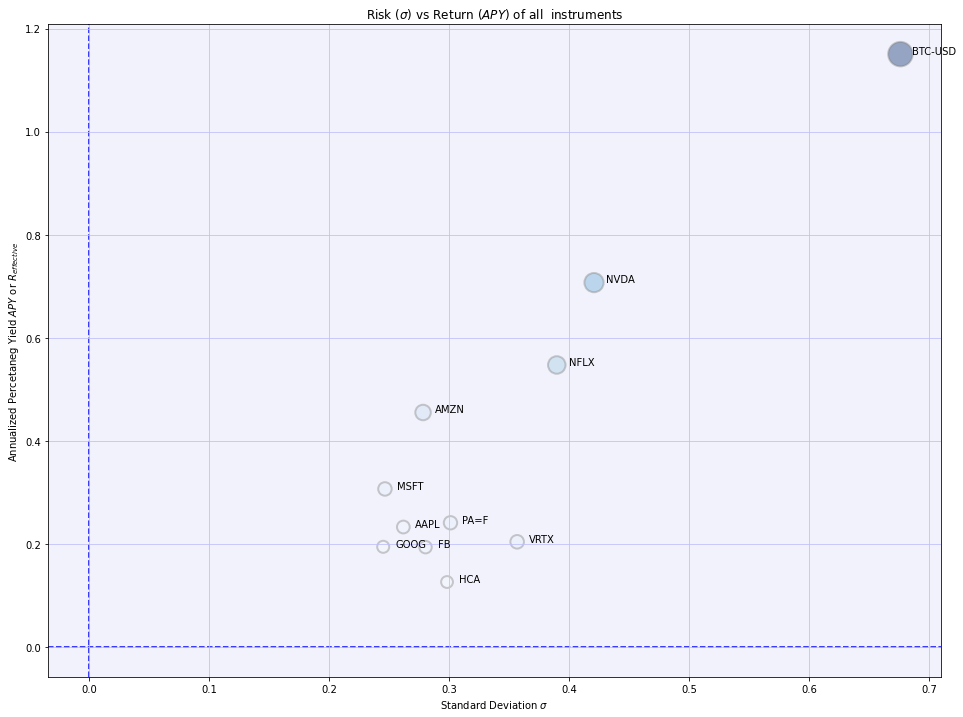

In [33]:
# configuration - generate different colors & sizes
c = [y + x for y, x in zip(APY_avg, STD_avg)]
c = list(map(lambda x : x /max(c), c))
s = list(map(lambda x : x * 600, c))


# plot
fig, ax = plt.subplots(figsize = (16,12))
ax.set_title(r"Risk ($\sigma$) vs Return ($APY$) of all  instruments")
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_xlabel(r"Standard Deviation $\sigma$")
ax.set_ylabel(r"Annualized Percetaneg Yield $APY$ or $R_{effective}$")
ax.scatter(STD_avg, APY_avg, s = s , c = c , cmap = "Blues", alpha = 0.4, edgecolors="grey", linewidth=2)
ax.axhline(y = 0.0,xmin = 0 ,xmax = 5,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')
ax.axvline(x = 0.0,ymin = 0 ,ymax = 40,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')
for idx, instr in enumerate(list(STD.columns)):
  ax.annotate(instr, (STD_avg[idx] + 0.01, APY_avg[idx]))



# 4 - Calculate Additional Descriptives 
---




## 4.0 - Configuration & Utility Function for visualization

In [34]:
instruments = list(log_returns.columns)
instruments

['AAPL',
 'MSFT',
 'AMZN',
 'GOOG',
 'FB',
 'NFLX',
 'NVDA',
 'HCA',
 'VRTX',
 'BTC-USD',
 'PA=F']

In [35]:
def visualize_statistic(statistic, title, limit = 0):
  # configuration
  fig, ax = plt.subplots(figsize = (12,8))
  ax.set_facecolor((0.95, 0.95, 0.99))
  ax.grid(c = (0.75, 0.75, 0.99), axis = 'y')
  colors = sns.color_palette('Reds', n_colors = len(statistic))
  # visualize
  barlist = ax.bar(x = np.arange(len(statistic)), height =  statistic)
  for b, c in zip(barlist, colors):
    b.set_color(c)
  ax.axhline(y = limit, xmin = -1 ,xmax = 1,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')

  # configure more
  for i, v in enumerate(statistic):
      ax.text( i - 0.22,v + 0.01 , str(round(v,3)), color = 'blue', fontweight='bold')
  plt.xticks(np.arange(len(statistic)), instruments)
  plt.title(r"{}for every instrument (i) against market (m) S&P500".format(title))
  plt.xlabel(r"Instrument")
  plt.ylabel(r"{} value".format(title))
  plt.show()



In [36]:
def visualize_model(alpha, beta, data, model):
  fig, axs = plt.subplots(4,3, figsize = (14,10),  constrained_layout = True)
  # fig.tight_layout()
  idx = 0
  R_m = data["^GSPC"]
  del data["^GSPC"]
  for a, b, instr in zip(alpha, beta, data):
    i, j = int(idx / 3), idx % 3
    axs[i, j].set_title("Model : {} fitted for '{}'".format(model, instr))
    axs[i, j].set_facecolor((0.95, 0.95, 0.99))
    axs[i, j].grid(c = (0.75, 0.75, 0.99))
    axs[i, j].set_xlabel(r"Market (S&P500) log returns")
    axs[i, j].set_ylabel(r"{} log returns".format(instr))
    
    R = data[instr]
    y = a + b * R_m
    axs[i, j].scatter(x = R_m, y = R, label = 'Returns'.format(instr))
    axs[i, j].plot(R_m, y ,color = 'red', label = 'CAPM model')
    idx += 1

## 4.1 - Expanded CAPM (CAPM & Single-Index Model)
$$E[R] - R_f = \alpha + \beta \cdot (E[R_m] - R_f) + \epsilon$$
We calulate $\alpha, \beta$ as followed :
* $\beta = \rho_{i,m}\frac{\sigma}{\sigma_m}$
* $\alpha = (\overline{E[R]} - R_f) - \beta \cdot (\overline{E[R_m]} - R_f)$

We can also calculate a,b by fitting a linear-regression model (OLS) of the format:
$$y = \alpha + \beta x$$

We have **1 feature $x$** : the market premium $x = (E[R_m] - R_f)$. We could have more **n features $(x_1,..., x_n)$** making the prediction for the $E[R]$ more accurate (probably?) 




### 4.1.1 - Risk-Free rate $R_f$ : 13-week T-bill (^IRX)

In [37]:
# [*] Risk-Free Asset : 13 Week Tbill (^IRX). Get the most recent value
risk_free = web.DataReader('^IRX', data_source = 'yahoo', start = start, end = end)['Adj Close']
risk_free = float(risk_free.tail(1))

In [38]:
print("Risk-Free rate (Daily T-bill) = {}".format(risk_free))

Risk-Free rate (Daily T-bill) = 0.10999999940395355


### 4.1.2 - Market $R_m$ : Assume S&P500 (^GSPC)
We load the time series for S&P500 with ticker ^GSPC. It is a 1331 x 1 dataframe (1-column because we keep only Adj. Close price). So we need first to merge market (m) with all instruments dataframe (i) to bring it on common date scale. After that we can calculate the respective `Descpritive Statistics` like before



In [39]:
# [*] Market          : S&P 500 index (^GSPC) | Yahoo Finance for index pricing, '^GSPC' is the underlying for 'SPX' options. 
market             = web.DataReader('^GSPC', data_source = 'yahoo', start = start, end = end)['Adj Close']
market             = market.rename("^GSPC")
market_log_returns = market.pct_change()
log_returns_total  = pd.concat([log_returns,market_log_returns], axis = 1).dropna()

In [40]:
# Descriptive statistics
# RETURN
log_returns_total = pd.concat([log_returns,market_log_returns], axis = 1).dropna()
APR_total         = log_returns_total.groupby([log_returns_total.index.year]).agg('sum')
APR_avg_total     = APR_total.mean()
APR_avg_market    = APR_avg_total['^GSPC']
# RISK
STD_total         = log_returns_total.groupby([log_returns_total.index.year]).agg('std') * np.sqrt(N)
STD_avg_total     = STD_total.mean()
STD_avg_market    = STD_avg_total['^GSPC']

In [41]:
pd.DataFrame(APR_avg_total, columns = ['Average APR']).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F,^GSPC
Average APR,0.209524,0.267724,0.375252,0.177883,0.177332,0.436706,0.535023,0.119011,0.185977,0.765976,0.216173,0.054124


In [42]:
pd.DataFrame(STD_avg_total, columns = ['Average STD']).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F,^GSPC
Average STD,0.262063,0.246729,0.278478,0.245277,0.280532,0.389887,0.420907,0.298447,0.356873,0.676164,0.301326,0.155027


## 4.2 - Find Correlation $\rho$ & R squared $R^2$
---

In [43]:
# Calculate correlation ρ & R squared R^2 between all instruments (i) & market (m)
corr = log_returns.corrwith(market_log_returns)
r_squared = corr ** 2

In [44]:
pd.DataFrame(r_squared, columns = ["R squared"]).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
R squared,0.553082,0.629146,0.309926,0.511554,0.399123,0.204431,0.353139,0.339481,0.278323,0.01183,0.031529


## 4.3 - Apply Expanded CAPM
---

In [45]:
############################################################
##          Expanded Capital Asset Pricing Model          ##
## ______________________________________________________ ##
##       E[R] - R_f  = α + β * (E[R_M] - R_f) + 𝜖         ##
##                                                        ##
##       INPUT :  [*] E[R] = log returns, σ = STD         ##
##       OUTPUT : [*] α,β                                 ##
############################################################
def CAPM():
  # 1 - Calculate average Risk Premium for every instrument  
  # [*]  _
  #     E[R] - R_f
  # [*]   __
  #     E[R_m] - R_f
  APR_premium        = APR_avg - risk_free
  APR_market_premium = APR_avg_market - risk_free

  # 2 - Calculate α, β
  beta  = corr *  STD_avg / STD_avg_market
  alpha = APR_premium - beta * APR_market_premium 
  
  return alpha, beta

In [46]:
alpha, beta = CAPM()


### 4.3.1 - Alpha α

In [47]:
pd.DataFrame(alpha,  columns = ["Average α"]).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average α,0.169769,0.22826,0.32113,0.131113,0.13121,0.390244,0.515176,0.071686,0.143836,0.682483,0.125458


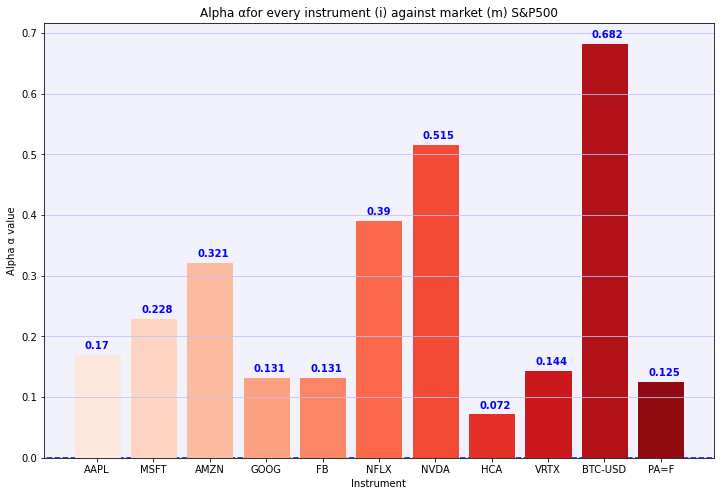

In [48]:
visualize_statistic(alpha.values, "Alpha α")

### 4.3.2 - Beta β

In [49]:
pd.DataFrame(beta,  columns = ["Average β"]).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average β,1.257171,1.262377,1.000031,1.131608,1.143219,1.137119,1.613442,1.121681,1.214457,0.474395,0.345134


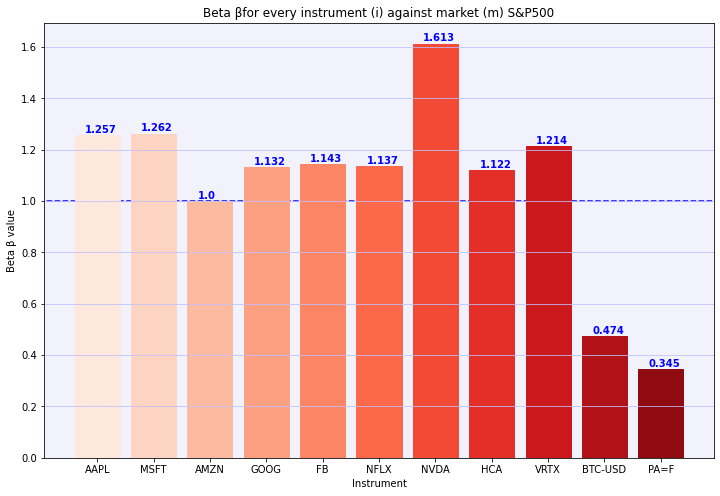

In [50]:
visualize_statistic(beta.values, "Beta β", limit = 1)

### 4.3.3 - Visualize data & CAPM

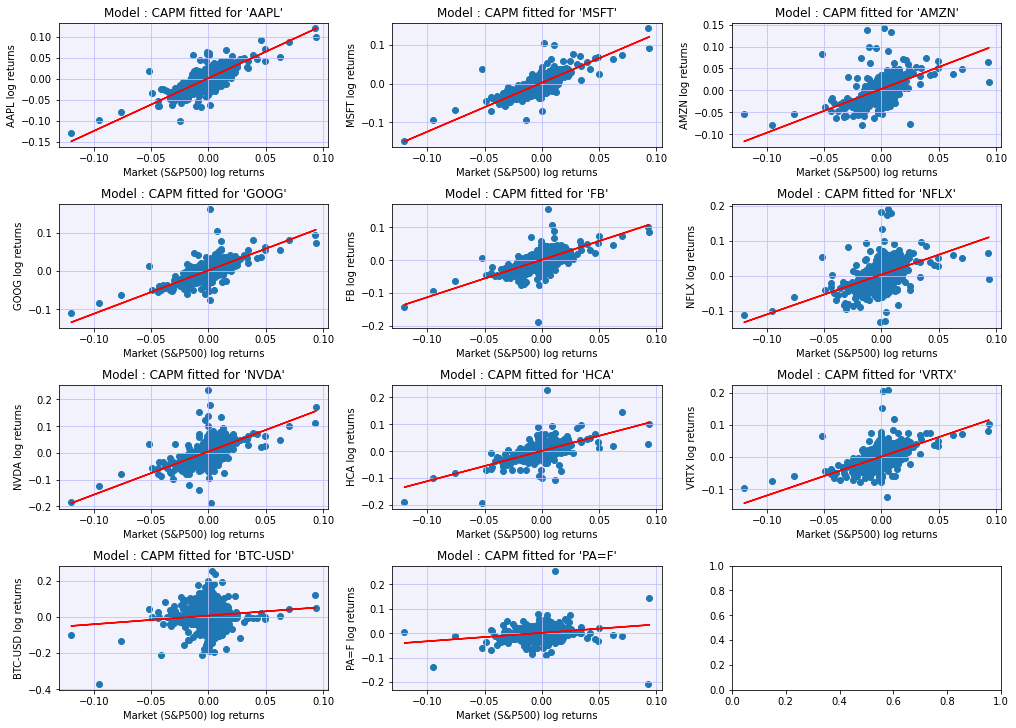

In [51]:
visualize_model(alpha/100, beta, data = log_returns_total.copy(), model = 'CAPM')

## 4.4 - Apply Linear Regression Model (OLS) $y = \alpha + \beta x$
---


In [52]:
beta_reg, alpha_reg = np.polyfit(x = log_returns_total['^GSPC'] , y = log_returns_total[log_returns.columns] ,deg = 1)

### 4.4.1 - Alpha α

In [53]:
pd.DataFrame(alpha_reg,  index = log_returns.columns ,columns = ["Average α"]).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average α,0.000691,0.000962,0.001535,0.000571,0.000564,0.001792,0.002149,0.000288,0.000591,0.003505,0.000939


### 4.4.2 - Beta β

In [54]:
pd.DataFrame(beta_reg,  index = log_returns.columns ,columns = ["Average β"]).T

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Average β,1.1676,1.18603,0.928312,1.053231,1.069502,1.061516,1.481123,1.071172,1.123198,0.445576,0.323402


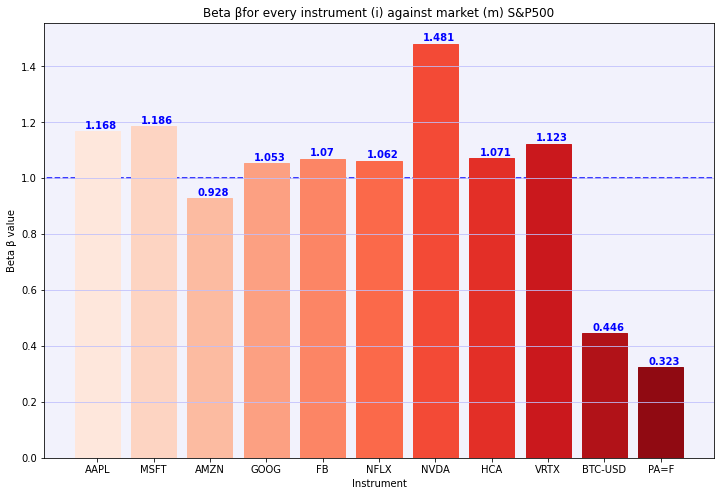

In [55]:
visualize_statistic(beta_reg, "Beta β", limit = 1)

### 4.4.3 - Visualize data & OLS

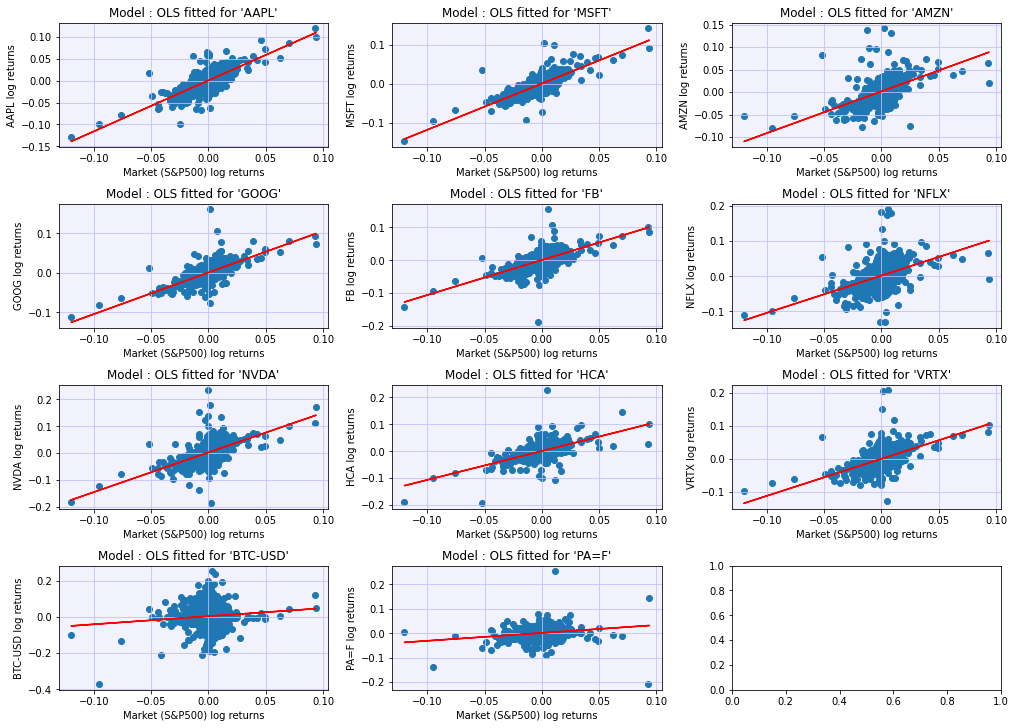

In [56]:
visualize_model(alpha_reg, beta_reg, data = log_returns_total.copy(), model = 'OLS')

# 5 - Portfolio Optimization
---

In [57]:
portfolios = {"#1 dummy (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
              "#1 dummy (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0}, 
              "#2 optimized max sr (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
              "#2 optimized max sr (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
              "#2 optimized min σ (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
              "#2 optimized min σ (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0}, 
              }

## 5.1 - Portfolio #1 (the dummy portfolio)

* 7 Stocks : 45% 
* 2 Bonds : 35%
* 2 Commodities : 10%



In [58]:
# WEIGHTS, RETURN, RISK
cov = APR.cov()
weights = np.array([ 0.45/ 7] * 7 + [ 0.35 / 2] * 2 + [ 0.1 / 2] * 2)
expected_return = np.sum(APR_avg * weights)
expected_risk   = np.sqrt( np.dot(weights.T , np.dot(cov, weights)) ) 

# RISKY PORTFOLIO
portfolios["#1 dummy (risky)"]["Return E[R]"]     = expected_return
portfolios["#1 dummy (risky)"]["Risk σ"]          = expected_risk
portfolios["#1 dummy (risky)"]["Sharpe Ratio SR"] = (expected_return - risk_free) / expected_risk

# TOTAL PORTFOLIO
total_expected_return = 0.9 * expected_return + 0.1 * risk_free
total_expected_risk   = 0.9 * expected_risk
portfolios["#1 dummy (total)"]["Return E[R]"]     = total_expected_return
portfolios["#1 dummy (total)"]["Risk σ"]          = total_expected_risk
portfolios["#1 dummy (total)"]["Sharpe Ratio SR"] = (total_expected_return - risk_free) / total_expected_risk

In [59]:
portfolios_df = pd.DataFrame(portfolios).T
portfolios_df

,Return E[R],Risk σ,Sharpe Ratio SR
#1 dummy (risky),0.242588,0.185080,0.716381
#1 dummy (total),0.229329,0.166572,0.716381
#2 optimized max sr (risky),0.000000,0.000000,0.000000
#2 optimized max sr (total),0.000000,0.000000,0.000000
#2 optimized min σ (risky),0.000000,0.000000,0.000000
#2 optimized min σ (total),0.000000,0.000000,0.000000


## 5.2 - Portfolio #2 (the optimized portfolio)

* 7 Stocks : ?
* 2 Bonds : ?
* 2 Commodities : ?

### 5.2.1 - Portfolio Simulation

In [60]:
num_portfolios = 10000
generated_portfolios = [] # store the results

for idx in range(num_portfolios) :
  # 1 - select random weights for portfolio holdings & rebalance weights to sum to 1
  weights = np.array(np.random.random(11))
  weights /= np.sum(weights)

  # 2 - calculate return, risk, sharpe ratio
  expected_return = np.sum(APR_avg * weights)
  expected_risk   = np.sqrt( np.dot(weights.T , np.dot(cov, weights)) ) 
  sharpe_ratio    = ( expected_return - risk_free) / expected_risk

  # 3 - store the result
  generated_portfolios.append([ expected_return, expected_risk, sharpe_ratio, weights] )

# Locate the 2 'special' portfolios 1) maximum sharpe ratio 2) minimum risk
maximum_sr_portfolio   = sorted(generated_portfolios, key = lambda x : -x[2])[0]
minimum_risk_portfolio = sorted(generated_portfolios, key = lambda x : x[1])[0]
max_sr = maximum_sr_portfolio[2]

max_sr_weights = pd.DataFrame(maximum_sr_portfolio[3], index = log_returns.columns ,columns = ["Optimal Weights  #2 optimized max sr "]).T
min_risk_weights = pd.DataFrame(minimum_risk_portfolio[3], index = log_returns.columns ,columns = ["Optimal Weights  #2 optimized min σ "]).T


In [61]:
max_sr_weights

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Optimal Weights #2 optimized max sr,0.041038,0.038036,0.251077,0.023373,0.016177,0.23872,0.160395,0.002469,0.007247,0.019474,0.201993


In [62]:
min_risk_weights

,AAPL,MSFT,AMZN,GOOG,FB,NFLX,NVDA,HCA,VRTX,BTC-USD,PA=F
Optimal Weights #2 optimized min σ,0.077133,0.179645,0.172326,0.012769,0.0119,0.144565,0.049519,0.157284,0.009119,0.003393,0.182347


In [63]:
# RISKY PORTFOLIOS
portfolios["#2 optimized max sr (risky)"]["Return E[R]"]     = maximum_sr_portfolio[0]
portfolios["#2 optimized max sr (risky)"]["Risk σ"]          = maximum_sr_portfolio[1]
portfolios["#2 optimized max sr (risky)"]["Sharpe Ratio SR"] = (maximum_sr_portfolio[0] - risk_free) / maximum_sr_portfolio[1]
portfolios["#2 optimized min σ (risky)"]["Return E[R]"]      = minimum_risk_portfolio[0]
portfolios["#2 optimized min σ (risky)"]["Risk σ"]           = minimum_risk_portfolio[1]
portfolios["#2 optimized min σ (risky)"]["Sharpe Ratio SR"]  = (minimum_risk_portfolio[0] - risk_free) / minimum_risk_portfolio[1]

# TOTAL PORTFOLIOS
total_expected_return = 0.9 * maximum_sr_portfolio[0] + 0.1 * risk_free
total_expected_risk   = 0.9 * maximum_sr_portfolio[1]
portfolios["#2 optimized max sr (total)"]["Return E[R]"]     = total_expected_return
portfolios["#2 optimized max sr (total)"]["Risk σ"]          = total_expected_risk
portfolios["#2 optimized max sr (total)"]["Sharpe Ratio SR"] = (total_expected_return - risk_free) / total_expected_risk
total_expected_return = 0.9 * minimum_risk_portfolio[0] + 0.1 * risk_free
total_expected_risk   = 0.9 * minimum_risk_portfolio[1]
portfolios["#2 optimized min σ (total)"]["Return E[R]"]      = total_expected_return
portfolios["#2 optimized min σ (total)"]["Risk σ"]           = total_expected_risk
portfolios["#2 optimized min σ (total)"]["Sharpe Ratio SR"]  = (total_expected_return - risk_free) / total_expected_risk

In [64]:
portfolios_df = pd.DataFrame(portfolios).T
portfolios_df

,Return E[R],Risk σ,Sharpe Ratio SR
#1 dummy (risky),0.242588,0.185080,0.716381
#1 dummy (total),0.229329,0.166572,0.716381
#2 optimized max sr (risky),0.370315,0.147009,1.770739
#2 optimized max sr (total),0.344283,0.132308,1.770739
#2 optimized min σ (risky),0.285362,0.103388,1.696150
#2 optimized min σ (total),0.267826,0.093049,1.696150


### 5.2.2 - Portfolio Simulation Visulization

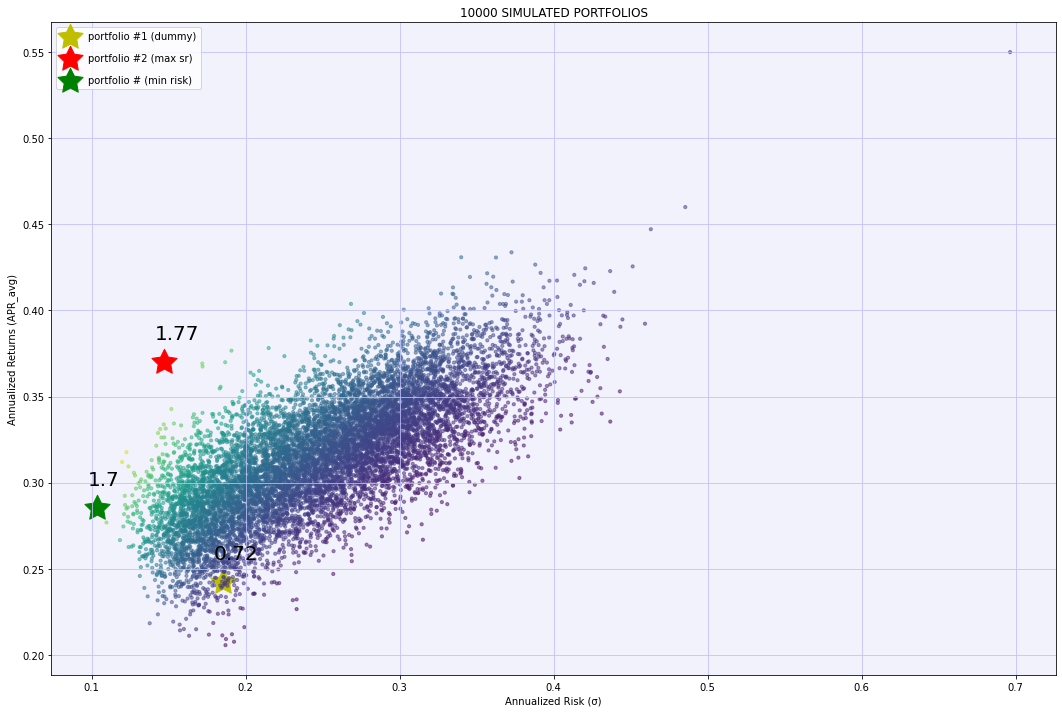

In [65]:
# plot the 2 optimized portfolios along with the rest 9998
def plot_simulation(CAL = None, INSTRUMENTS = None) :
  fig, ax = plt.subplots(figsize = (18,12))
  ax.set_facecolor((0.95, 0.95, 0.99))
  ax.grid(c = (0.75, 0.75, 0.99))
  # portfolio #1
  ret  = portfolios["#1 dummy (risky)"]["Return E[R]"]
  risk = portfolios["#1 dummy (risky)"]["Risk σ"]
  sr   = (ret - risk_free) / risk
  ax.scatter(risk, ret, marker = (5,1,0),color = 'y',s = 700, label = 'portfolio #1 (dummy)')
  ax.annotate(round(sr, 2), (risk - 0.006,ret + 0.013),  fontsize = 20, color = 'black')
 
  # portfolio #2
  ret, risk, sr = [x[0] for x in generated_portfolios], [x[1] for x in generated_portfolios], [x[2] for x in generated_portfolios]
  ax.scatter(risk, ret, c = sr, cmap = 'viridis', marker = 'o', s = 10, alpha = 0.5)
  ax.scatter(maximum_sr_portfolio[1], maximum_sr_portfolio[0],marker = (5,1,0),color = 'r',s = 700, label = 'portfolio #2 (max sr)')
  ax.annotate(round(maximum_sr_portfolio[2], 2), (maximum_sr_portfolio[1]  - 0.006,maximum_sr_portfolio[0] + 0.013), fontsize = 20, color = 'black')
  ax.scatter(minimum_risk_portfolio[1], minimum_risk_portfolio[0], marker = (5,1,0), color = 'g',s = 700,  label = 'portfolio # (min risk)')
  ax.annotate(round(minimum_risk_portfolio[2], 2), (minimum_risk_portfolio[1]  - 0.006,minimum_risk_portfolio[0] + 0.013), fontsize = 20, color = 'black')
  # CAL? EFFICIENT FRONTIER?
  if CAL : 
    for cal in CAL:
      ax.plot(cal[0], ca[1], linestyle = '-', color = 'red', label = 'CAL')

  if INSTRUMENTS : 
    ax.scatter(STD_avg, APR_avg, s = s , c = c , cmap = "Blues", alpha = 0.4, edgecolors = "grey", linewidth = 2)
    for idx, instr in enumerate(list(STD.columns)):
      sr = round((APR_avg[idx] - risk_free) / STD_avg[idx] , 2)
      ax.annotate(instr, (STD_avg[idx] + 0.01, APR_avg[idx]))
      ax.annotate(sr, (STD_avg[idx] - 0.005 , APR_avg[idx] + 0.015))

  ax.set_title('10000 SIMULATED PORTFOLIOS')
  ax.set_xlabel('Annualized Risk (σ)')
  ax.set_ylabel('Annualized Returns (APR_avg)')
  ax.legend(labelspacing = 1.2)

plot_simulation()


### 5.2.3 - Capital Allocation Line (CAL)
One Capital Allocation line per portfolio. It is the frontier when taking into account the risk free instrument in the portfolio.

In [66]:
##################################################################
#						            E[R_optimal] - R_rf 				             #
#			E[R_p] = R_rf + ---------------------- σ_p 			           #
#									           σ_optimal				                   #
#							        |                     |                    #
#                     |_____________________|                    #
#                            SR_optimal                          #
##################################################################
cal_x  = np.linspace(0.0, 0.3, 50)
cal_y = risk_free + cal_x * max_sr

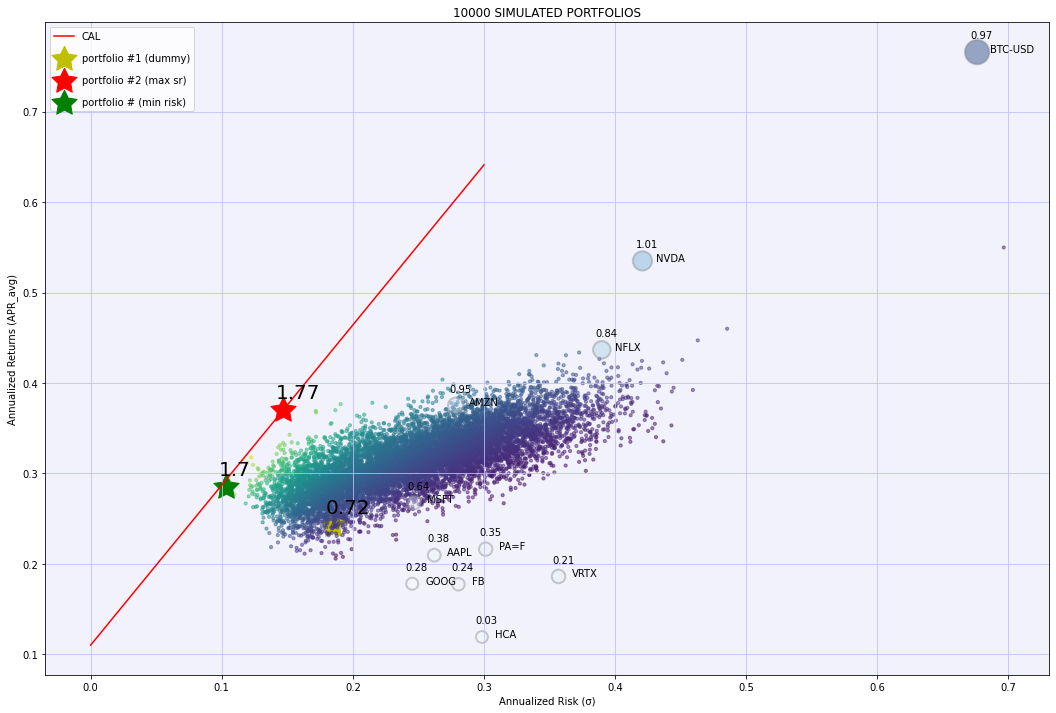

In [67]:
plot_simulation(CAL = [cal_x, cal_y] , INSTRUMENTS = 'yes')

# 6 - Utility Function
---
$$U = E[r] - \frac{1}{2}A\sigma^2$$

In [111]:
A = np.linspace(0, 10, 10)
utility_dummy    = portfolios["#1 dummy (total)"]["Return E[R]"] - 1/2 * A * portfolios["#1 dummy (total)"]["Risk σ"] ** 2
utility_max_sr   = portfolios["#2 optimized max sr (total)"]["Return E[R]"] - 1/2 * A * portfolios["#2 optimized max sr (total)"]["Risk σ"] ** 2
utility_min_risk = portfolios["#2 optimized min σ (total)"]["Return E[R]"] - 1/2 * A * portfolios["#2 optimized min σ (total)"]["Risk σ"] ** 2

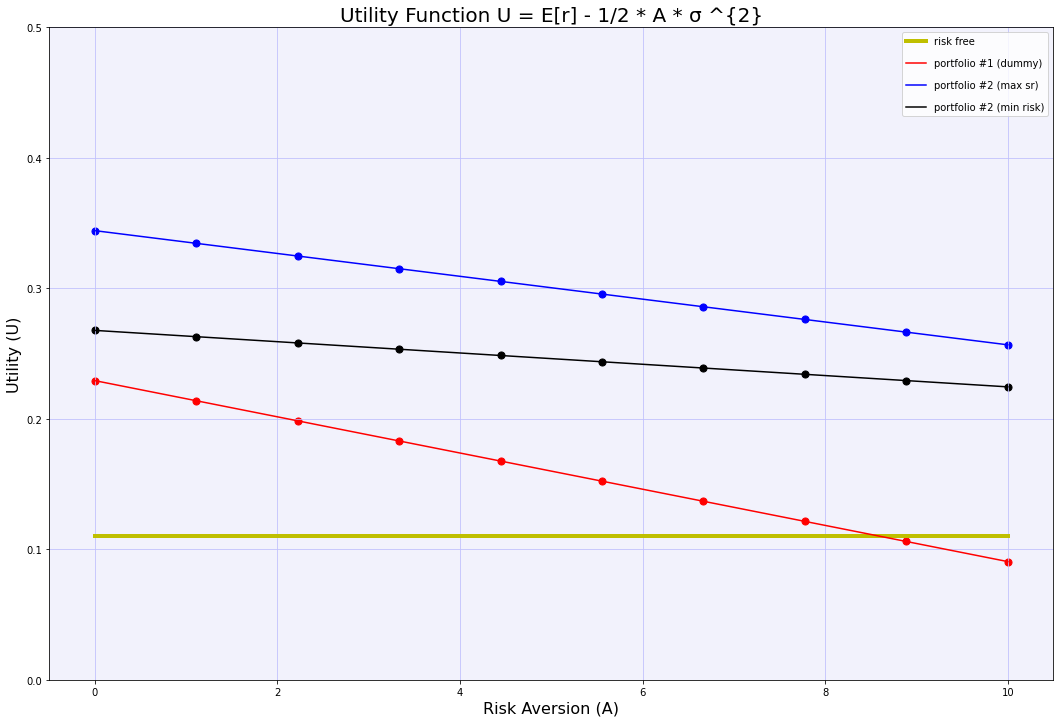

In [112]:
fig, ax = plt.subplots(figsize = (18,12))
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

# Risk Free
ax.plot(A, [risk_free] * 10, color = 'y', label = 'risk free', linewidth = 4)

# Portfolio #1
ax.scatter(A, utility_dummy, color = 'r',s = 50)
ax.plot(A, utility_dummy, color = 'r', label = 'portfolio #1 (dummy)')

# Portfolio #2 (max sr)
ax.scatter(A, utility_max_sr, color = 'b',s = 50)
ax.plot(A, utility_max_sr, color = 'b', label = 'portfolio #2 (max sr)')

# Portfolio #2 (min risk)
ax.scatter(A, utility_min_risk, color = 'black',s = 50)
ax.plot(A, utility_min_risk, color = 'black', label = 'portfolio #2 (min risk)')

ax.set_title('Utility Function U = E[r] - 1/2 * A * σ ^{2}', fontsize = 20)
ax.set_xlabel('Risk Aversion (A)', fontsize = 16)
ax.set_ylabel('Utility (U)', fontsize = 16)
ax.set_ylim([0, 0.5])
ax.legend(labelspacing = 1.2)



# 7 - Final Evaluation
---

In [110]:
portfolio = portfolios["#2 optimized max sr (total)"]
ret       = portfolio['Return E[R]']
risk      = portfolio['Risk σ']
sr        = portfolio['Sharpe Ratio SR']
utility   = ret - 1/2 * 3 * risk ** 2

portfolio = pd.DataFrame([str(round(ret * 100, 2)) + "%", str(round(risk * 100, 2)) + "%", sr, str(round(utility * 100, 2) ) + "%"], index = ['Return E[R]', 'Risk σ', 'Sharpe Ratio SR', 'Utility U'] ,columns = ["Portfolio #2 optimized max sr "]).T
portfolio

,Return E[R],Risk σ,Sharpe Ratio SR,Utility U
Portfolio #2 optimized max sr,34.43%,13.23%,1.77074,31.8%
